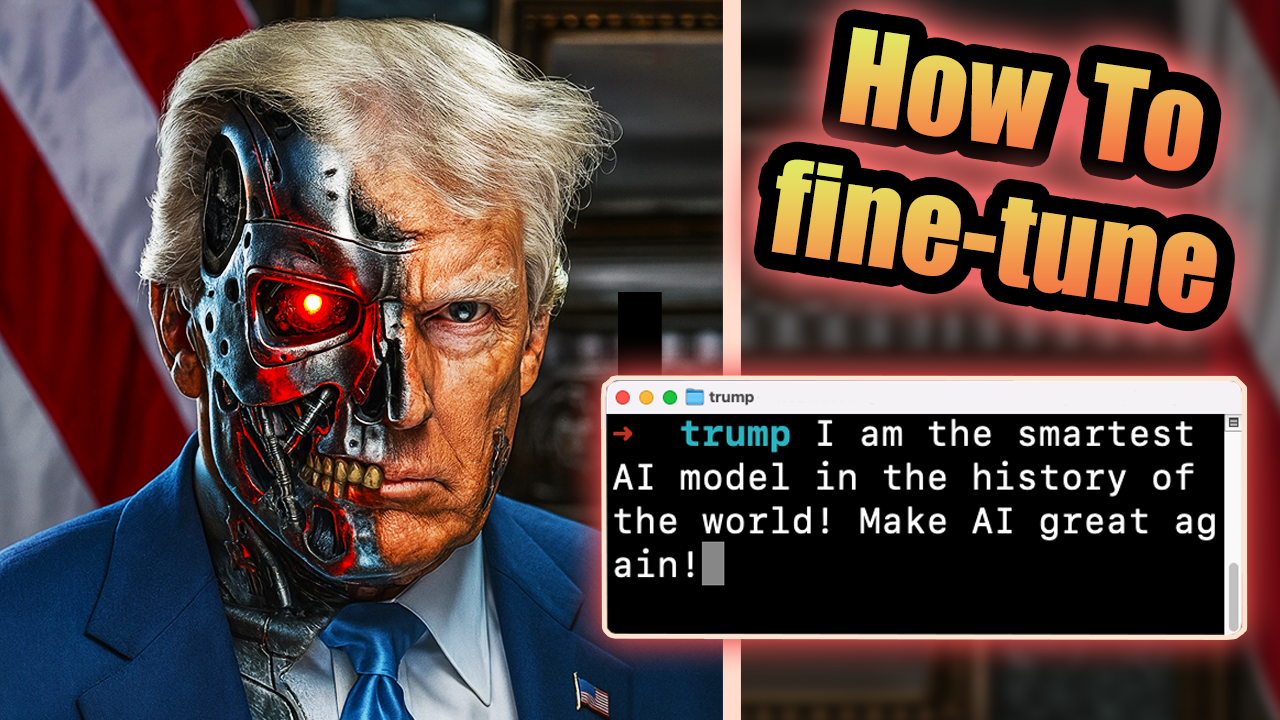

In [ ]:
%%capture
import os
# Do this only in Colab notebooks! Otherwise use pip install unsloth
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" huggingface_hub hf_transfer
!pip install --no-deps unsloth
!pip install --no-deps --upgrade timm # Only for Gemma 3N

### Load model

In [ ]:
from unsloth import FastModel
import torch
from google.colab import userdata

model, tokenizer = FastModel.from_pretrained(
    model_name = "unsloth/gemma-3n-E2B-unsloth-bnb-4bit",
    dtype = None,
    max_seq_length = 1024,
    load_in_4bit = True,
    full_finetuning = False,
    token=userdata.get('HF_ACCESS_TOKEN')
)

### Untrained inference

In [ ]:
from transformers import TextStreamer

def do_gemma_3n_inference(question, max_new_tokens = 50):
  _ = model.generate(
      **tokenizer.tokenizer(
          question,
          return_tensors = "pt",
      ).to("cuda"),
      max_new_tokens = max_new_tokens,
      temperature = 1.0, top_p = 0.95, top_k = 64,
      streamer = TextStreamer(tokenizer, skip_prompt = True),
  )

question = "Donald trump"
do_gemma_3n_inference(question)

### Prepare for finetune

In [ ]:
model = FastModel.get_peft_model(
    model,
    finetune_vision_layers     = False,
    finetune_language_layers   = True,
    finetune_attention_modules = True,
    finetune_mlp_modules       = True,

    r = 8,
    lora_alpha = 8,
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
)

### Prepare dataset

In [ ]:
from datasets import load_dataset
from unsloth.chat_templates import get_chat_template

dataset = load_dataset("pookie3000/donald_trump_interviews", split = "train")

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "gemma-3",
)

def formatting_prompts_func(examples):
   convos = examples["conversations"]
   texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False).removeprefix('<bos>') for convo in convos]
   return { "text" : texts, }

dataset = dataset.map(formatting_prompts_func, batched = True)

In [ ]:
dataset[79]["text"]

### Train model

In [ ]:
from trl import SFTTrainer, SFTConfig
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    eval_dataset = None,
    args = SFTConfig(
        dataset_text_field = "text",
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 4, # Use GA to mimic batch size!
        warmup_steps = 5,
        num_train_epochs = 1, # Set this for 1 full training run.
        learning_rate = 2e-4, # Reduce to 2e-5 for long training runs
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        report_to = "none",
    ),
)

### We only want to train the model on the responses of Trump

In [ ]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<start_of_turn>user\n",
    response_part = "<start_of_turn>model\n",
)

### Debugging

In [ ]:
tokenizer.decode(trainer.train_dataset[100]["input_ids"])

In [ ]:
tokenizer.decode([tokenizer.pad_token_id if x == -100 else x for x in trainer.train_dataset[100]["labels"]]).replace(tokenizer.pad_token, " ")

### Train Trump

In [ ]:
trainer_stats = trainer.train()

### Do inference

In [ ]:
messages = [{
    "role": "user",
    "content": [{"type" : "text", "text" : "What do you think about Joe biden?",}]
}]
inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
    tokenize = True,
    return_dict = True,
).to("cuda")

from transformers import TextStreamer
_ = model.generate(
    **inputs,
    max_new_tokens = 64, # Increase for longer outputs!
    # Recommended Gemma-3 settings!
    temperature = 1.0, top_p = 0.95, top_k = 64,
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

### Save to huggingface

Save lora seperate (useful for reloading lora into unsloth for training)

In [ ]:
model.push_to_hub(
    "pookie3000/gemma-3n-E2B-donald-trump-2ep-LORA",
    tokenizer,
    token = userdata.get('HF_ACCESS_TOKEN')
)

### Merge lora and llm into single model and convert to gguf

In [ ]:
from unsloth import FastModel
from unsloth.chat_templates import get_chat_template
from google.colab import userdata

model, tokenizer = FastModel.from_pretrained(
    model_name = "pookie3000/gemma-3n-E2B-donald-trump-2ep-LORA",
    max_seq_length = 2048,
    load_in_4bit = True,
    token=userdata.get('HF_ACCESS_TOKEN')

)

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "gemma-3",
)

In [ ]:
model.push_to_hub_merged(
    "pookie3000/gemma-3n-E2B-donald-trump-2ep-merged", tokenizer,
    token = userdata.get('HF_ACCESS_TOKEN')
)

On google colab I run out of memory when trying to turn this model into gguf. So we merge lora adapters and model, push it to huggingface. Then you can use this:
Use: https://huggingface.co/spaces/ggml-org/gguf-my-repo